# Linear regression from scratch

Powerful ML libraries can eliminate repetitive work, but if you rely too much on abstractions, you might never learn how neural networks really work under the hood. So for this first example, let's get our hands dirty and build everything from scratch, relying only on autograd and NDArray. First, we'll import the same dependencies as in the [autograd chapter](./P01-C05-autograd.ipynb):

In [1]:
import mxnet as mx
from mxnet import nd, autograd
mx.random.seed(1)

## Linear regression


We'll focus on the problem of linear regression. Given a collection of data points ``X``, and corresponding target values ``y``, we'll try to find the line, parameterized by a vector ``w`` and intercept ``b`` that approximately best associates data points ``X[i]`` with their corresponding labels ``y[i]``. Using some proper math notation, we want to learn a prediction 

$$\boldsymbol{\hat{y}} = X \cdot \boldsymbol{w} + b$$

that minimizes the squared error across all examples 

$$\sum_{i=1}^n (\hat{y}_i-y_i)^2.$$

You might notice that linear regression is an ancient model and wonder why we would present a linear model as the first example in a tutorial series on neural networks. Well it turns out that we can express linear regression as the simplest possible (useful) neural network. A neural network is just a collection of nodes (aka neurons) connected by directed edges. In most networks, we arrange the nodes into layers with each taking input from the nodes below. To calculate the value of any node, we first perform a weighted sum of the inputs (according to weights ``w``) and then apply an *activation function*. For linear regression, we have two layers, the input (depicted in orange) and a single output node (depicted in green) and the activation function is just the identity function.

In this picture, we visualize all of the components of each input as orange circles.

![](https://raw.githubusercontent.com/zackchase/mxnet-the-straight-dope/master/img/simple-net-linear.png)

To make things easy, we're going to work with a synthetic data where we know the solution, by generating random data points ``X[i]`` and labels ``y[i] = 2 * X[i][0]- 3.4 * X[i][1] + 4.2 + noise`` where the noise is drawn from a random gaussian with mean ``0`` and variance ``.1``.

In mathematical notation we'd say that the true labeling function is 
$$y = X \cdot w + b + \eta, \quad \text{for } \eta \sim \mathcal{N}(0,\sigma^2)$$


In [2]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

X = nd.random_normal(shape=(num_examples, num_inputs))
y = 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2 + .01 * nd.random_normal(shape=(num_examples,))

Notice that each row in ``X`` consists of a 2-dimensional data point and that each row in ``Y`` consists of a 1-dimensional target value. 

In [3]:
print(X[0])
print(y[0])


[-0.67765152  0.03629481]
<NDArray 2 @cpu(0)>

[ 2.74159384]
<NDArray 1 @cpu(0)>


We can confirm that for any randomly chosen point, a linear combination with the (known) optimal parameters produces a prediction that is indeed close to the target value

In [4]:
print(2 * X[0, 0] - 3.4 * X[0, 1] + 4.2)


[ 2.7212944]
<NDArray 1 @cpu(0)>


We can visualize the correspondence between our second feature (``X[:, 1]``) and the target values ``Y`` by generating a scatter plot with the Python plotting package ``matplotlib``.

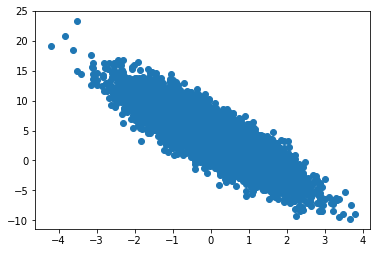

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1].asnumpy(),y.asnumpy())
plt.show()

## Data iterators

Once we start working with neural networks, we're going to need to iterate through our data points quickly. We'll also want to be able to grab batches of ``k`` data points at a time, to shuffle our data. In MXNet, data iterators give us a nice set of utilities for fetching and manipulating data. In particular, we'll work with the simple  ``NDArrayIter`` class.

In [6]:
batch_size = 4
train_data = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(X, y),
                                      batch_size=batch_size, shuffle=True)

Once we've initialized our NDArrayIter (``train_data``), we can easily fetch batches by calling ``train_data.next()``. ``batch.data`` gives us a list of inputs. Because our model has only one input (``X``), we'll just be grabbing ``batch.data[0]``.

In [7]:
for data, label in train_data:
    print(data, label)
    break

(
[[-0.0289653  -1.13240516]
 [ 1.01206839  0.93944538]
 [-0.22727819  0.33262748]
 [ 0.42817059  0.92713743]]
<NDArray 4x2 @cpu(0)>, 
[ 8.00228691  3.03088069  2.62427664  1.92212093]
<NDArray 4 @cpu(0)>)


Finally, we can iterate over ``train_data`` just as though it were an ordinary Python list:

In [8]:
counter = 0
for data, label in train_data:
    counter += 1
print(counter)

2500


## Model parameters

Now let's allocate some memory for our parameters and set their initial values.

In [9]:
w = nd.random_normal(shape=(num_inputs, num_outputs))
b = nd.random_normal(shape=num_outputs)
params = [w, b]

In the succeeding cells, we're going to update these parameters to better fit our data. This will involve taking the gradient (a multi-dimensional derivative) of some *loss function* with respect to the parameters. We'll update each parameter in the direction that reduces the loss. But first, let's just allocate some memory for each gradient.

In [10]:
for param in params:
    param.attach_grad()

## Neural networks

Next we'll want to define our model. In this case, we'll be working with linear models, the simplest possible *useful* neural network. To calculate the output of the linear model, we simply multipy a given input with the model's weights (``w``), and add the offset ``b``.

In [11]:
def net(X):
    return mx.nd.dot(X, w) + b

Ok, that was easy.

## Loss function

Train a model means making it better and better over the course of a period of training. But in order for this goal to make any sense at all, we first need to define what *better* means in the first place. In this case, we'll use the squared distance between our prediction and the true value. 

In [12]:
def square_loss(yhat, y): 
    return nd.mean((yhat - y) ** 2)

## Optimizer

It turns out that linear regression actually has a closed-form solution. However, most interesting models that we'll care about cannot be solved analytically. So we'll solve this problem by stochastic gradient descent. At each step, we'll estimate the gradient of the loss with respect to our weights, using one batch randomly drawn from our dataset. Then, we'll update our parameters a small amount in the direction that reduces the loss. The size of the step is determined by the *learning rate* ``lr``. 

In [13]:
def SGD(params, lr):    
    for param in params:
        param[:] = param - lr * param.grad

## Execute training loop

Now that we have all the pieces all we have to do is wire them together by writing a training loop. First we'll define ``epochs``, the number of passes to make over the dataset. Then for each pass, we'll iterate through ``train_data``, grabbing batches of examples and their corresponding labels. 

For each batch, we'll go through the following ritual:
* Generate predictions (``yhat``) and the loss (``loss``) by executing a forward pass through the network.
* Calculate gradients by making a backwards pass through the network (``loss.backward()``). 
* Update the model parameters by invoking our SGD optimizer.

In [14]:
epochs = 2
ctx = mx.cpu()
learning_rate = .001
moving_loss = 0.


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx).reshape((-1, 1))
        with autograd.record():
            output = net(data)
            mse = square_loss(output, label)
        mse.backward()
        SGD(params, learning_rate)
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        if (i == 0) and (e == 0):
            moving_loss = nd.mean(mse).asscalar()
        else:
            moving_loss = .99 * moving_loss + .01 * nd.mean(mse).asscalar()

        if (i + 1) % 500 == 0:
            print("Epoch %s, batch %s. Moving avg of loss: %s" % (e, i, moving_loss))       

Epoch 0, batch 499. Moving avg of loss: 8.63019604838
Epoch 0, batch 999. Moving avg of loss: 1.1305851623
Epoch 0, batch 1499. Moving avg of loss: 0.15926257825
Epoch 0, batch 1999. Moving avg of loss: 0.0243555015711
Epoch 0, batch 2499. Moving avg of loss: 0.00300907929247
Epoch 1, batch 499. Moving avg of loss: 0.00046650203316
Epoch 1, batch 999. Moving avg of loss: 0.000155705979639
Epoch 1, batch 1499. Moving avg of loss: 0.00010803343968
Epoch 1, batch 1999. Moving avg of loss: 9.78388428569e-05
Epoch 1, batch 2499. Moving avg of loss: 0.000100409757858


## Conclusion 

You've seen that using just mxnet.ndarray and mxnet.autograd, we can build statistical models from scratch. In the following tutorials, we'll build on this foundation, introducing the basic ideas between modern neural networks and powerful abstractions in MXNet for building comples models with little code. 

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)